# GoogLeNet

This notebook is an implement of [___Going deeper with convolutions___](https://arxiv.org/pdf/1409.4842.pdf) by Szedegy et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and thus takes less space to store on clusters and less time for training. 

We first need to install and import all the dependent libraries in the session.

In [1]:
! pip install -r ../requirements.txt

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-01-15 13:51:08.293473: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-15 13:51:20.676097: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-15 13:51:20.780848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0035:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-15 13:51:20.780885: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-15 13:51:20.788389: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-15 13:51:20.788430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set and test set. 

In [2]:
batch_size = 64

def get_data():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    
    train_x = train_x / 255.0
    test_x = test_x / 255.0
    
    train_size = len(train_y) * 8 // 10

    train = tf.data.Dataset.from_tensor_slices((train_x[:train_size], 
                                                train_y[:train_size])).shuffle(train_size).batch(batch_size)
    val = tf.data.Dataset.from_tensor_slices((train_x[train_size:], 
                                              train_y[train_size:])).batch(batch_size)
    test = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch_size)
    
    return train, val, test

train, val, test = get_data()

2022-01-15 13:51:22.648814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0035:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-15 13:51:22.651233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
2022-01-15 13:51:22.652633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0035:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-15 13:51:22.655021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
2022-01-15 13:51:22.655051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1256] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-01-15 13:51:22.655059: I tensorflow/core/com

This is function that constructs a GoogLeNet model. In ```inception``` function we constructs an inception block while in ```createGoogLeNet``` function we build a fine-tuned GoogLeNet model. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. The most important change is that we only keep four inception layers because the images are very small and deep network would only cause overfitting instead of increasing performance. We define ```weight_decay``` as the hyperparameters of the model for kernel regularization.

In [3]:
def inception(input, f1, f3r, f3, f5r, f5, pp, weight_decay, output = False, output_name = None):
    x1 = Conv2D(kernel_size = 1, filters = f1, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(input)
    
    x2 = Conv2D(kernel_size = 1, filters = f3r, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(input)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(kernel_size = 3, filters = f3, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(x2)
    
    x3 = Conv2D(kernel_size = 1, filters = f5r, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(input)
    x3 = BatchNormalization()(x3)
    x3 = Conv2D(kernel_size = 5, filters = f5, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(x3)
     
    x4 = MaxPooling2D(pool_size = 3, padding = "same", strides = 1)(input)
    x4 = Conv2D(kernel_size = 1, filters = pp, activation = "relu", padding = "same", kernel_regularizer = l2(weight_decay))(x4)
    
    x5 = None
    
    if output == True:
        x5 = GlobalAveragePooling2D()(x)
        x5 = Conv2D(kernel_size = 1, padding = "same", filters = 128, activation = "relu", kernel_regularizer = l2(weight_decay))(x5)
        x5 = BatchNormalization()(x5)
        x5 = Flatten()(x5)
        x5 = Dense(1024, activation = "relu", kernel_regularizer = l2(weight_decay))(x5)
        x5 = Dropout(rate = .7)(x5)
        x5 = Dense(10, activation = "softmax", name = output_name)(x5)
    
    x = Concatenate()([x1, x2, x3, x4])
    x = BatchNormalization()(x)
    x = Dropout(.3)(x)
    return x, x5

def createGoogLeNet(weight_decay):
    input = Input(shape = (32, 32, 3), name = "image")
    x, _ = inception(input, 64, 96, 128, 16, 32, 32, weight_decay)
    x, _ = inception(x, 128, 128, 192, 32, 96, 64, weight_decay)
    x, _ = inception(x, 192, 96, 208, 16, 48, 64, weight_decay)
    x, _ = inception(x, 160, 112, 224, 24, 64, 64, weight_decay)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(rate = .7)(x)
    output = Dense(10, activation = "softmax", name = "out")(x)

    model = tf.keras.Model(inputs = [input], outputs = [output], name = "GoogLeNet")

    return model


This part trains the GoogLeNet model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on server so that we can continue training even if the session disconnects. We also add learning rate scheduler to slow down learning rate when validation loss stops increasing. We show the result of the training process with a graph about the training and validation accuracy for each epoch. 

Epoch 1/60


2022-01-15 13:51:27.946244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-15 13:51:27.991876: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3783000000 Hz
2022-01-15 13:51:28.923061: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-15 13:51:29.273292: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-01-15 13:51:29.756447: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-15 13:51:30.054959: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


625/625 [==============================] - 56s 82ms/step - loss: 147.9233 - accuracy: 0.3009 - val_loss: 86.0882 - val_accuracy: 0.2038


2022-01-15 13:52:25.372769: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/assets
Epoch 2/60
625/625 [==============================] - 50s 80ms/step - loss: 54.7954 - accuracy: 0.4521 - val_loss: 33.4263 - val_accuracy: 0.3619
INFO:tensorflow:Assets written to: weights/assets
Epoch 3/60
625/625 [==============================] - 50s 80ms/step - loss: 21.9502 - accuracy: 0.5188 - val_loss: 14.1352 - val_accuracy: 0.4706
INFO:tensorflow:Assets written to: weights/assets
Epoch 4/60
625/625 [==============================] - 51s 81ms/step - loss: 9.8298 - accuracy: 0.5660 - val_loss: 7.2632 - val_accuracy: 0.4982
INFO:tensorflow:Assets written to: weights/assets
Epoch 5/60
625/625 [==============================] - 50s 79ms/step - loss: 5.3383 - accuracy: 0.5986 - val_loss: 4.4506 - val_accuracy: 0.5344
INFO:tensorflow:Assets written to: weights/assets
Epoch 6/60
625/625 [==============================] - 50s 79ms/step - loss: 3.5514 - accuracy: 0.6339 - val_loss: 3.1734 - val_accuracy: 0.5990
INFO:tensorflow:Assets wri

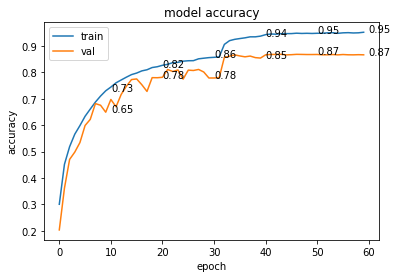

In [4]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "val_loss", verbose = 0, 
                                        save_best_only = True, mode = "auto")
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                          verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model = createGoogLeNet(.1)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights") 

history = model.fit(train, epochs = 60, validation_data = val, callbacks = [cp, lr])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

for i, (acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
    if (i + 1) % 10 == 0:
        plt.annotate("{:.2f}".format(acc), xy = (i + 1, acc))
        plt.annotate("{:.2f}".format(val_acc), xy = (i + 1, val_acc))

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()


Here we test our model on test set and show how GoogLeNet predicts on sample images in the test set.

157/157 [==============================] - 3s 21ms/step - loss: 0.7112 - accuracy: 0.8574
Test Accuracy: 85.74%


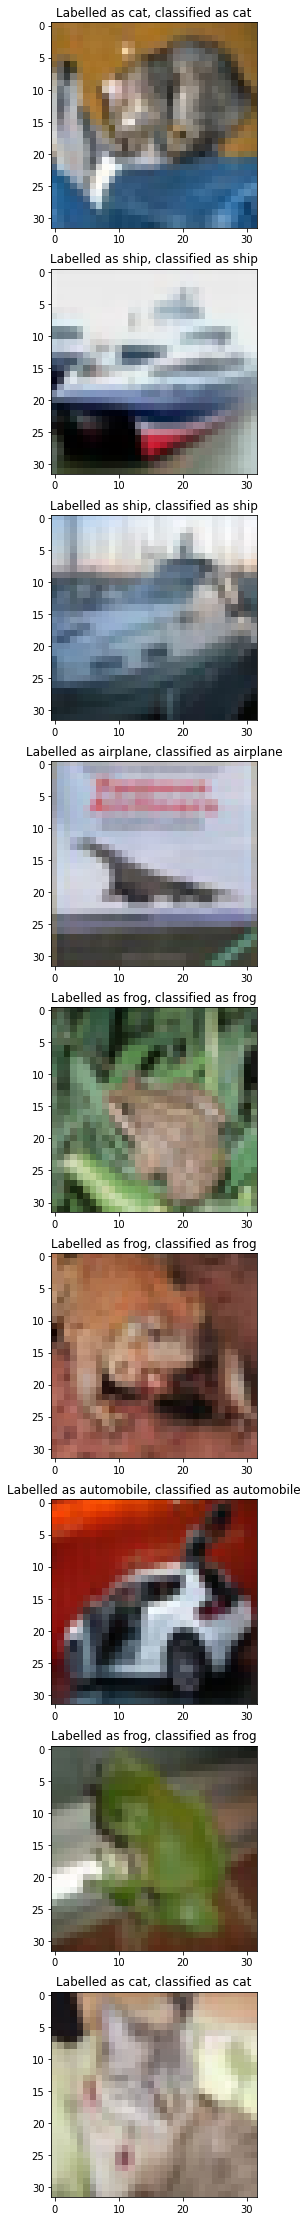

In [5]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print("Test Accuracy: {:.2%}".format(model.evaluate(test)[1]))

fig = plt.figure(figsize = (10, 40))
for sample_data, sample_label in test.take(1):
    pred = np.argmax(model.predict(sample_data), axis = 1)
    
    for i, (img, label) in enumerate(zip(sample_data[:9], sample_label[:9])):
        ax = fig.add_subplot(911 + i)
        ax.imshow(img)


        ax.set_title("Labelled as " + labels[int(label)] + ", classified as " + labels[int(pred[i])])